In [14]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import libraries and dependencies
import numpy as np
import pandas as pd
#import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame

In [15]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    "PK53SYJTCXUMSM6B9J16",
    "H9P38bh7EGcoqOeDsAb2hQqIp8bCZgFfiO8K2IKO",
    api_version='v2')

df = alpaca.get_bars("SP", TimeFrame.Hour, "2023-01-01", "2023-02-01", adjustment='raw').df

# Drop columns
df = df.drop(columns=["volume","trade_count","vwap"])

# Add trade_type column
df["trade_type"] = ""

# Review top rows from dataframe
df.head()

,open,high,low,close,trade_type
timestamp,,,,,
2023-01-03 14:00:00+00:00,34.900,34.90,34.765,34.87,
2023-01-03 15:00:00+00:00,34.875,35.03,34.770,35.01,
2023-01-03 16:00:00+00:00,35.020,35.02,34.590,34.71,
2023-01-03 17:00:00+00:00,34.690,34.86,34.690,34.72,
2023-01-03 18:00:00+00:00,34.800,35.04,34.800,34.95,


In [16]:
previous_price = 0

for index, row in df.iterrows():
    if previous_price == 0:
        df.loc[index, 'trade_type'] = "buy"
    elif row["close"] < previous_price:
        df.loc[index, "trade_type"] = "buy"
    elif row["close"] > previous_price:
        df.loc[index, "trade_type"] = "sell"
    else:
        df.loc[index, "trade_type"] = "hold"
        
    previous_price = row["close"]
    
    if index==df.index[-1]:
        df.loc[index, "trade_type"] = "sell"

In [17]:
# Review top rows from dataframe
df.head()

,open,high,low,close,trade_type
timestamp,,,,,
2023-01-03 14:00:00+00:00,34.900,34.90,34.765,34.87,buy
2023-01-03 15:00:00+00:00,34.875,35.03,34.770,35.01,sell
2023-01-03 16:00:00+00:00,35.020,35.02,34.590,34.71,buy
2023-01-03 17:00:00+00:00,34.690,34.86,34.690,34.72,sell
2023-01-03 18:00:00+00:00,34.800,35.04,34.800,34.95,sell


In [18]:
# Create an empty list containing the price patters (bullish, bearish, neutral)
price_patterns = [""]

for i in range(len(df)-1):
    
    # BULLISH PRICE PATTERNS
    
    # 1. Bullish "Quasi" Engulfing Pattern
    if (df.iloc[i+1]["close"] >= df.iloc[i]["open"] and df.iloc[i+1]["high"] > df.iloc[i]["high"] and df.iloc[i+1]["low"] < df.iloc[i]["low"]):
        price_patterns.append("buy entry")
        
    # 2. "Neutral" Harami (at Support)
    elif (df.iloc[i]["close"] < df.iloc[i]["open"] and df.iloc[i+1]["high"] < df.iloc[i]["high"] and df.iloc[i+1]["low"] > df.iloc[i]["low"]):
        price_patterns.append("buy entry")
        
    # 3. Double Candlestick LOW w/ higher HIGH and HIGH CLOSE
    elif (df.iloc[i+1]["low"] == df.iloc[i]["low"] and df.iloc[i+1]["close"] > df.iloc[i]["close"] and df.iloc[i+1]["high"] > df.iloc[i]["high"]):
        price_patterns.append("buy entry")
    
    # BEARISH PRICE PATTENRS
    
    # 1. Bearish "Quasi" Engulfing Pattern
    elif (df.iloc[i+1]["close"] <= df.iloc[i]["open"] and df.iloc[i+1]["high"] > df.iloc[i]["high"] and df.iloc[i+1]["low"] < df.iloc[i]["low"]):
        price_patterns.append("sell entry")
        
    # 2. "Neutral" Harami (at Support)
    elif (df.iloc[i]["close"] > df.iloc[i]["open"] and df.iloc[i+1]["high"] < df.iloc[i]["high"] and df.iloc[i+1]["low"] > df.iloc[i]["low"]):
        price_patterns.append("sell entry")
        
    # 3. Double Candlestick HIGH w/ Lower LOW and Lower CLOSE
    elif (df.iloc[i+1]["high"] == df.iloc[i]["high"] and df.iloc[i+1]["close"] < df.iloc[i]["close"] and df.iloc[i+1]["low"] < df.iloc[i]["low"]):
        price_patterns.append("sell entry")
    
    # NEUTRAL
    else:
        price_patterns.append("")
        
# Add Strategy column to our dataframe
df["strategy_price_patterns"] = price_patterns

# Review top rows from dataframe
df.head(20)

,open,high,low,close,trade_type,strategy_price_patterns
timestamp,,,,,,
2023-01-03 14:00:00+00:00,34.9000,34.9000,34.7650,34.8700,buy,
2023-01-03 15:00:00+00:00,34.8750,35.0300,34.7700,35.0100,sell,
2023-01-03 16:00:00+00:00,35.0200,35.0200,34.5900,34.7100,buy,
2023-01-03 17:00:00+00:00,34.6900,34.8600,34.6900,34.7200,sell,buy entry
2023-01-03 18:00:00+00:00,34.8000,35.0400,34.8000,34.9500,sell,
2023-01-03 19:00:00+00:00,34.9200,34.9200,34.5900,34.7800,buy,
2023-01-03 20:00:00+00:00,34.7700,34.8600,34.6400,34.7800,hold,buy entry
2023-01-03 21:00:00+00:00,34.8100,34.8100,34.8100,34.8100,sell,sell entry
2023-01-04 14:00:00+00:00,34.9500,35.4600,34.6300,35.2700,sell,buy entry


In [19]:
# Review top rows from dataframe
df["real_exit"] = ""

#############

is_in_trade = False
close_price_in_trade = df.iloc[0]["close"]
real_exit_list = []

for i in range(len(df)):
    if is_in_trade == False:
        if df.iloc[i]["strategy_price_patterns"] == "":
            real_exit_list.append("")
        elif df.iloc[i]["strategy_price_patterns"] == "buy entry":
            is_in_trade = True
            close_price_in_trade = df.iloc[i]["close"]
            real_exit_list.append("")
        else:
            is_in_trade = True
            close_price_in_trade = df.iloc[i]["close"]
            real_exit_list.append("")
    
    else:
        if(df.iloc[i]["strategy_price_patterns"]!=""):
            df.at[df.reset_index()['timestamp'][i], 'strategy_price_patterns'] = ""
        if df.iloc[i]["close"] >= close_price_in_trade + 0.5:
            real_exit_list.append("sell exit")  
            is_in_trade = False
        elif df.iloc[i]["close"] <= close_price_in_trade - 0.5:
            real_exit_list.append("buy exit")  
            is_in_trade = False
        else:
            real_exit_list.append("")

##############

df["real_exit"] = real_exit_list

# Review top rows from dataframe
df.head(50)

,open,high,low,close,trade_type,strategy_price_patterns,real_exit
timestamp,,,,,,,
2023-01-03 14:00:00+00:00,34.9000,34.9000,34.7650,34.8700,buy,,
2023-01-03 15:00:00+00:00,34.8750,35.0300,34.7700,35.0100,sell,,
2023-01-03 16:00:00+00:00,35.0200,35.0200,34.5900,34.7100,buy,,
2023-01-03 17:00:00+00:00,34.6900,34.8600,34.6900,34.7200,sell,buy entry,
2023-01-03 18:00:00+00:00,34.8000,35.0400,34.8000,34.9500,sell,,
2023-01-03 19:00:00+00:00,34.9200,34.9200,34.5900,34.7800,buy,,
2023-01-03 20:00:00+00:00,34.7700,34.8600,34.6400,34.7800,hold,,
2023-01-03 21:00:00+00:00,34.8100,34.8100,34.8100,34.8100,sell,,
2023-01-04 14:00:00+00:00,34.9500,35.4600,34.6300,35.2700,sell,,sell exit


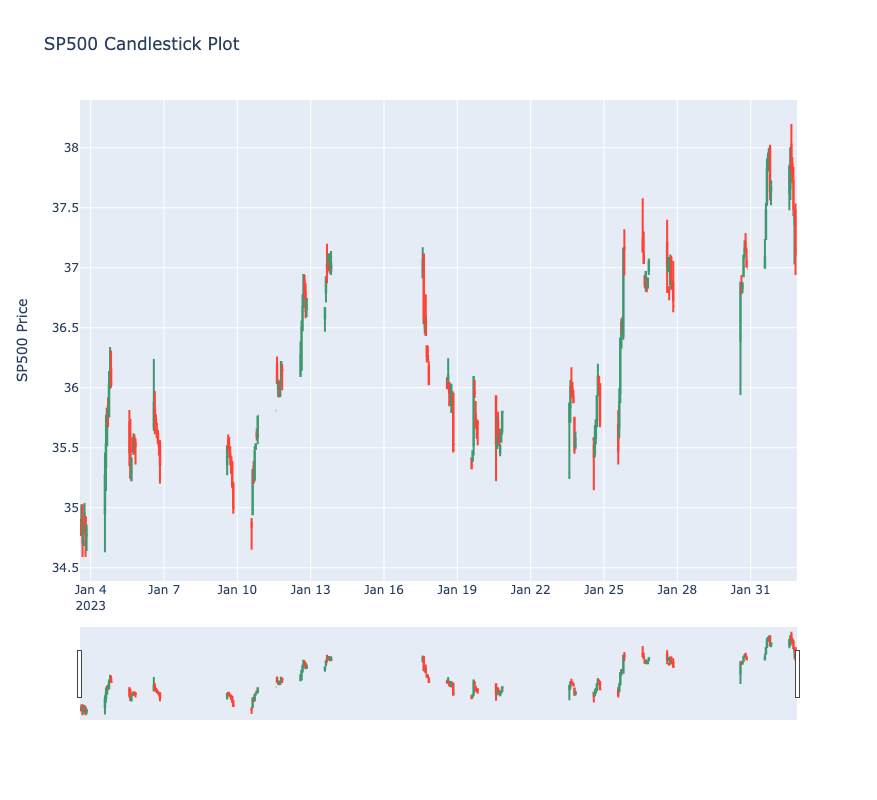

In [20]:
# Build candlestick plot
fig = go.Figure(data=[
    
                # Hourly Data
                go.Candlestick(
                    x=df.index,
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close']
                )
                ]
            )

def custom_legend_name(new_names):
    for i, new_name in enumerate(new_names):
        fig.data[i].name = new_name
        
custom_legend_name(['price'])

fig.update_layout(
    title='SP500 Candlestick Plot',
    yaxis_title='SP500 Price',
)

fig.update_layout(autosize=False, width=1600, height=800)
fig.show()